# Working With Fits Files



*Enhancements have been provided by Maria Pavlou as code changes to the base CDBDeep repo.*

In [1]:
# Allow reloading of CSBDeep modules following any code changes
%reload_ext autoreload
%autoreload 2

# A couple required imports
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
from pathlib import Path

# Pre-processing Training Data and Save

We have a stack of sub frames in the `data/astro/NGC6888` folder, acquired with the same optical train and equipment.

All images have been aligned and calibrated and saved in the tiff format.

The example data can be downloaded [here](https://1drv.ms/u/s!AvWEkn9Anb_Nq9Aw52Xs3LuYEcq_rg?e=EexXxL)

Place the train images in the `data/astro/NGC6888` folder.

In [2]:
# Setup Data Parameters:
# Root Data path
basepath=Path('data/astro')
# Train Data path/s
source_dirs=['NGC6888']
# Image file pattern. Note: only formats supported by imread currently
pattern='*.fits'
# Image patch size
patchsize=64
# Training data output savefile path & name
training_data_name='NGC6888_p64_nPERC'
training_data_filename=training_data_name + '.npz'
save_file=basepath/training_data_filename

# Define Image Loaders

In order to various image types not supported by `imread` and provide flexibility we define custom loader functions which can be used with `RawData.from_folder_n2n`

In the bellow examples we use the [astropy package](https://www.astropy.org/) to load fits files, and packages [colour_demosaicing](https://github.com/colour-science/colour-demosaicing), [colour_hdri](https://github.com/colour-science/colour-hdri) to process and demosaic the raw data.

Note, fits files can store varied data in many formats. Pre-processing of this data is up to you as defined in the loader.

In [3]:
from astropy.io import fits
from colour_demosaicing import  demosaicing_CFA_Bayer_bilinear, demosaicing_CFA_Bayer_Malvar2004, demosaicing_CFA_Bayer_Menon2007
from colour_hdri.plotting import plot_radiance_image_strip

def fits_loader_RGB(file):
    fitHDUL = fits.open(file)
    imagedata = fitHDUL[0].data
    fitHDUL.close()
    return np.transpose(imagedata)

def fits_loader_CFA(file):
    fitHDUL = fits.open(file, uint=False)
    fitHDUL.info()
    imagedata = fitHDUL[0].data    
    fitHDUL.close()    
    return demosaicing_CFA_Bayer_Menon2007(imagedata/65535,'RGGB')

In [4]:
# Make an estimate of the number of non-overlapping patches for the images we have, sampling from the first we find.
first_image_file = list((basepath/source_dirs[0]).glob(pattern))[0]
sampleimage = fits_loader_RGB(first_image_file)    
n_patches_per_image=np.int(sampleimage.shape[0]/patchsize)*np.int(sampleimage.shape[1]/patchsize)

In [5]:
from csbdeep.data import RawData, create_patches, norm_percentiles, norm_reinhard
from csbdeep.data import NoPreProcessor, ReinhardPreProcessor

# Load image pairs for Noise2Noise processing, each image paired against every other at most once.
raw_data = RawData.from_folder_n2n(basepath, source_dirs=source_dirs, axes='YXC', pattern=pattern, preprocessor=NoPreProcessor(), imageloader=fits_loader_RGB)

# Create patch data from image pairs with parameters,
# normalization set as norm_percentiles() by default, optionally set to None, norm_reinhard() or other custom
X, Y, XY_axes = create_patches(
    raw_data, 
    patch_size=(patchsize,patchsize,3),
    normalization=norm_percentiles(),
    n_patches_per_image=n_patches_per_image,
    save_file=save_file,
    patch_filter=None,
    overlap=False)

print('Source Data Shape =', X.shape)
print('Target Data Shape =', Y.shape)
print('Data Axes =', XY_axes)

    3 raw images x    1 transformations   =     3 images
    3 images     x 2816 patches per image =  8448 patches in total
Input data:
data\astro:, sources='['NGC6888']', axes='YXC', pattern='*.fits'
Transformations:
1 x Identity
Patch size:
64 x 64 x 3


100%|██████████| 3/3 [00:09<00:00,  3.18s/it]


Saving data to data\astro\NGC6888_p64_nPERC.npz.
Source Data Shape = (8448, 3, 64, 64)
Target Data Shape = (8448, 3, 64, 64)
Data Axes = SCYX


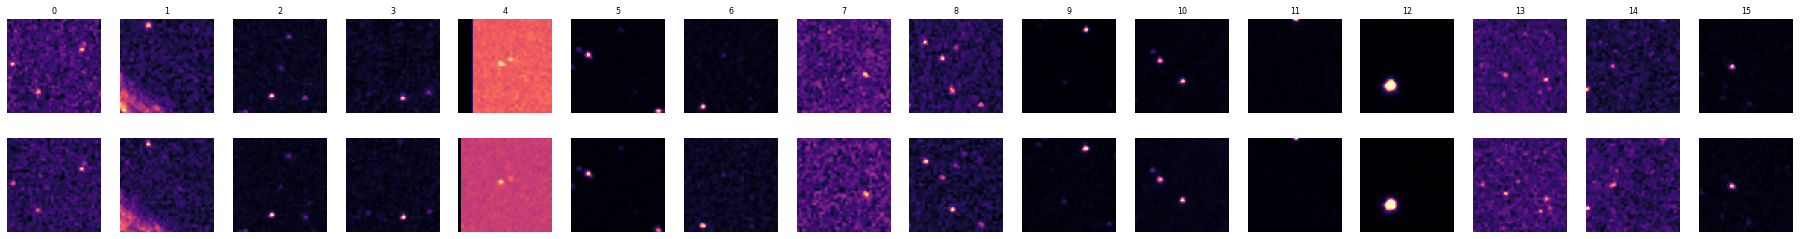

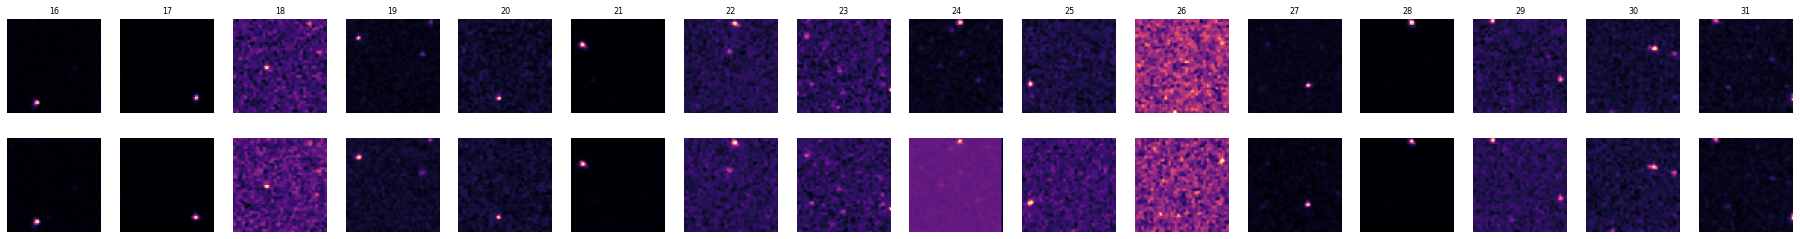

In [7]:
from csbdeep.utils import plot_some

# We can visualize the resulting patch input and target pairs.
for i in range(2):
    plt.figure(figsize=(32,4))
    sl = slice(16*i, 16*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()